# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.72KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

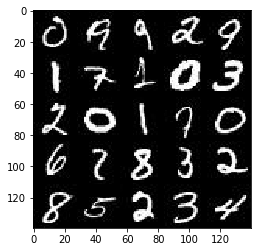

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

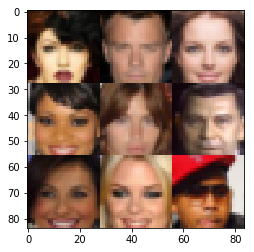

In [3]:
show_n_images = 15

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim))
    lr = tf.placeholder(tf.float32)
    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
ALPHA = 0.01
lrelu = lambda x: tf.maximum(ALPHA * x, x)

In [20]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 64, 5, 2, 'same')
        x = lrelu(x)
        
        x = tf.layers.conv2d(x, 128, 5, 2, 'same')
        x = lrelu(x)
        x = tf.layers.batch_normalization(x, training=True)
        
        x = tf.layers.conv2d(x, 256, 5, 2, 'same')
        x = lrelu(x)
        x = tf.layers.batch_normalization(x, training=True)
        
        x = tf.reshape(x, shape=(-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = lrelu(x)
        x = tf.layers.batch_normalization(x, training=is_train)
        
        x = tf.layers.conv2d_transpose(x, 128, 5, 2, 'same')
        x = lrelu(x)
        x = tf.layers.batch_normalization(x, training=is_train)
        
        x = tf.layers.conv2d_transpose(x, 64, 5,  2, 'same')
        x = lrelu(x)
        x = tf.layers.batch_normalization(x, training=is_train)
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, 1, 'same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_out_real, d_logits_real = discriminator(input_real)
    d_out_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_out_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_out_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_out_fake)))
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    u_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in u_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in u_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_train_op = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_train_op = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return (d_train_op, g_train_op)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_op, g_train_op = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                d_dict = { input_real: batch_images, input_z: batch_z }
                g_dict = { input_z: batch_z }
                _ = sess.run(d_train_op, feed_dict=d_dict)
                _ = sess.run(g_train_op, feed_dict=g_dict)
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval(d_dict)
                    train_loss_g = g_loss.eval(g_dict)
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2965... Generator Loss: 14.3529
Epoch 1/2... Discriminator Loss: 0.7766... Generator Loss: 1.8100
Epoch 1/2... Discriminator Loss: 0.3062... Generator Loss: 9.2273
Epoch 1/2... Discriminator Loss: 8.6168... Generator Loss: 0.0874
Epoch 1/2... Discriminator Loss: 2.5594... Generator Loss: 0.2196
Epoch 1/2... Discriminator Loss: 3.3938... Generator Loss: 0.3654
Epoch 1/2... Discriminator Loss: 1.6495... Generator Loss: 2.5429
Epoch 1/2... Discriminator Loss: 1.3466... Generator Loss: 0.6064
Epoch 1/2... Discriminator Loss: 2.2693... Generator Loss: 0.2506
Epoch 1/2... Discriminator Loss: 2.0909... Generator Loss: 0.2093


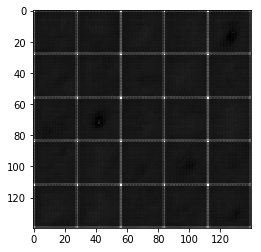

Epoch 1/2... Discriminator Loss: 2.3756... Generator Loss: 0.1575
Epoch 1/2... Discriminator Loss: 0.8898... Generator Loss: 1.1044
Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 2.7180
Epoch 1/2... Discriminator Loss: 1.5434... Generator Loss: 0.4513
Epoch 1/2... Discriminator Loss: 1.3585... Generator Loss: 0.6085
Epoch 1/2... Discriminator Loss: 1.7170... Generator Loss: 0.4461
Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 0.6440
Epoch 1/2... Discriminator Loss: 2.1282... Generator Loss: 3.5639
Epoch 1/2... Discriminator Loss: 1.1307... Generator Loss: 1.5062
Epoch 1/2... Discriminator Loss: 0.8607... Generator Loss: 1.2698


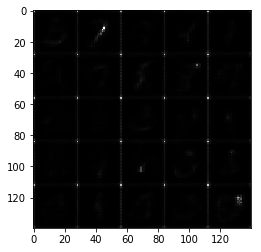

Epoch 1/2... Discriminator Loss: 1.2731... Generator Loss: 2.3349
Epoch 1/2... Discriminator Loss: 0.7183... Generator Loss: 1.2240
Epoch 1/2... Discriminator Loss: 1.5344... Generator Loss: 0.3961
Epoch 1/2... Discriminator Loss: 0.7014... Generator Loss: 1.4799
Epoch 1/2... Discriminator Loss: 2.6598... Generator Loss: 0.1751
Epoch 1/2... Discriminator Loss: 1.9546... Generator Loss: 0.2501
Epoch 1/2... Discriminator Loss: 0.7966... Generator Loss: 1.5154
Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 0.6826
Epoch 1/2... Discriminator Loss: 0.8286... Generator Loss: 1.2306
Epoch 1/2... Discriminator Loss: 1.8589... Generator Loss: 0.3073


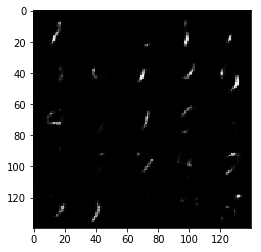

Epoch 1/2... Discriminator Loss: 1.3492... Generator Loss: 0.4499
Epoch 1/2... Discriminator Loss: 1.0059... Generator Loss: 0.9370
Epoch 1/2... Discriminator Loss: 1.2593... Generator Loss: 0.5200
Epoch 1/2... Discriminator Loss: 1.2425... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 0.9818... Generator Loss: 0.8496
Epoch 1/2... Discriminator Loss: 1.3544... Generator Loss: 0.5031
Epoch 1/2... Discriminator Loss: 1.0821... Generator Loss: 0.8274
Epoch 1/2... Discriminator Loss: 1.0048... Generator Loss: 1.0980
Epoch 1/2... Discriminator Loss: 1.5454... Generator Loss: 0.3546
Epoch 1/2... Discriminator Loss: 1.1110... Generator Loss: 1.7454


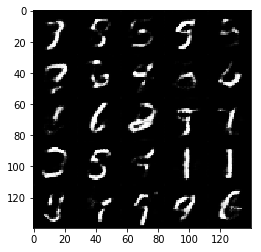

Epoch 1/2... Discriminator Loss: 1.2281... Generator Loss: 0.5889
Epoch 1/2... Discriminator Loss: 1.7999... Generator Loss: 0.3884
Epoch 1/2... Discriminator Loss: 1.0340... Generator Loss: 0.8449
Epoch 1/2... Discriminator Loss: 0.7036... Generator Loss: 1.2290
Epoch 1/2... Discriminator Loss: 0.8126... Generator Loss: 1.6447
Epoch 1/2... Discriminator Loss: 1.3032... Generator Loss: 0.6507
Epoch 1/2... Discriminator Loss: 0.9573... Generator Loss: 0.8706
Epoch 1/2... Discriminator Loss: 1.0092... Generator Loss: 0.7890
Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 2.4938
Epoch 1/2... Discriminator Loss: 1.2225... Generator Loss: 0.5585


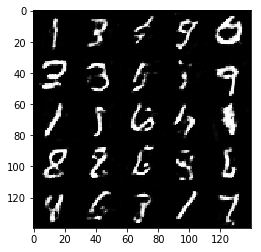

Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 0.7653
Epoch 1/2... Discriminator Loss: 0.8435... Generator Loss: 1.2092
Epoch 1/2... Discriminator Loss: 3.5230... Generator Loss: 0.0761
Epoch 1/2... Discriminator Loss: 0.7324... Generator Loss: 1.1667
Epoch 1/2... Discriminator Loss: 1.4595... Generator Loss: 0.3995
Epoch 1/2... Discriminator Loss: 2.1617... Generator Loss: 0.1886
Epoch 1/2... Discriminator Loss: 0.9669... Generator Loss: 1.4752
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.4851... Generator Loss: 0.4247
Epoch 1/2... Discriminator Loss: 0.6505... Generator Loss: 1.5689


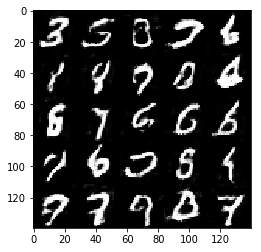

Epoch 1/2... Discriminator Loss: 0.7654... Generator Loss: 1.5614
Epoch 1/2... Discriminator Loss: 1.0893... Generator Loss: 0.6752
Epoch 1/2... Discriminator Loss: 0.8029... Generator Loss: 1.3117
Epoch 1/2... Discriminator Loss: 1.0951... Generator Loss: 0.7403
Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 1.5263
Epoch 1/2... Discriminator Loss: 0.9020... Generator Loss: 1.4533
Epoch 1/2... Discriminator Loss: 0.9368... Generator Loss: 0.9138
Epoch 1/2... Discriminator Loss: 1.5262... Generator Loss: 0.4515
Epoch 1/2... Discriminator Loss: 0.8246... Generator Loss: 1.0757
Epoch 1/2... Discriminator Loss: 0.9360... Generator Loss: 2.0331


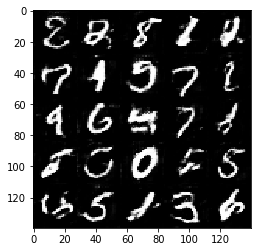

Epoch 1/2... Discriminator Loss: 1.0854... Generator Loss: 0.7080
Epoch 1/2... Discriminator Loss: 0.8540... Generator Loss: 1.9254
Epoch 1/2... Discriminator Loss: 2.1034... Generator Loss: 0.2766
Epoch 1/2... Discriminator Loss: 1.6776... Generator Loss: 0.3709
Epoch 1/2... Discriminator Loss: 0.8138... Generator Loss: 1.2465
Epoch 1/2... Discriminator Loss: 0.7640... Generator Loss: 1.4278
Epoch 1/2... Discriminator Loss: 0.5885... Generator Loss: 1.4064
Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 0.4657
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 1.8352
Epoch 1/2... Discriminator Loss: 1.8178... Generator Loss: 0.3533


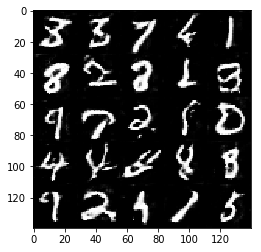

Epoch 1/2... Discriminator Loss: 1.8222... Generator Loss: 0.3478
Epoch 1/2... Discriminator Loss: 0.7862... Generator Loss: 0.9330
Epoch 1/2... Discriminator Loss: 0.6008... Generator Loss: 1.2379
Epoch 1/2... Discriminator Loss: 3.0589... Generator Loss: 0.0906
Epoch 1/2... Discriminator Loss: 2.0015... Generator Loss: 0.2658
Epoch 1/2... Discriminator Loss: 0.7210... Generator Loss: 1.0135
Epoch 1/2... Discriminator Loss: 1.3676... Generator Loss: 0.5433
Epoch 1/2... Discriminator Loss: 0.9062... Generator Loss: 0.9565
Epoch 1/2... Discriminator Loss: 1.2594... Generator Loss: 0.6392
Epoch 1/2... Discriminator Loss: 0.9731... Generator Loss: 0.9082


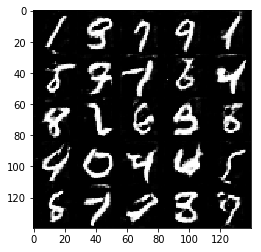

Epoch 1/2... Discriminator Loss: 1.5696... Generator Loss: 0.4173
Epoch 1/2... Discriminator Loss: 1.1865... Generator Loss: 0.7832
Epoch 1/2... Discriminator Loss: 0.7657... Generator Loss: 1.0072
Epoch 2/2... Discriminator Loss: 1.3957... Generator Loss: 0.4893
Epoch 2/2... Discriminator Loss: 1.9724... Generator Loss: 0.2915
Epoch 2/2... Discriminator Loss: 0.6453... Generator Loss: 1.2963
Epoch 2/2... Discriminator Loss: 1.3048... Generator Loss: 0.5290
Epoch 2/2... Discriminator Loss: 0.3372... Generator Loss: 2.0199
Epoch 2/2... Discriminator Loss: 1.2963... Generator Loss: 0.4828
Epoch 2/2... Discriminator Loss: 1.6082... Generator Loss: 0.4666


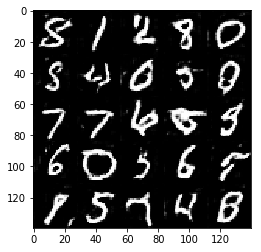

Epoch 2/2... Discriminator Loss: 1.1396... Generator Loss: 0.5777
Epoch 2/2... Discriminator Loss: 1.6717... Generator Loss: 0.3496
Epoch 2/2... Discriminator Loss: 1.0595... Generator Loss: 0.9683
Epoch 2/2... Discriminator Loss: 0.9395... Generator Loss: 1.1174
Epoch 2/2... Discriminator Loss: 1.4324... Generator Loss: 0.4108
Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 0.7030
Epoch 2/2... Discriminator Loss: 1.1740... Generator Loss: 0.6304
Epoch 2/2... Discriminator Loss: 1.2910... Generator Loss: 0.5662
Epoch 2/2... Discriminator Loss: 1.3410... Generator Loss: 0.5279
Epoch 2/2... Discriminator Loss: 0.8266... Generator Loss: 0.9070


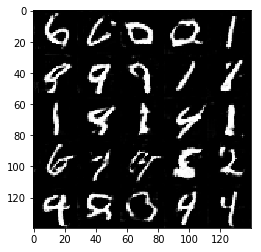

Epoch 2/2... Discriminator Loss: 0.3997... Generator Loss: 1.7606
Epoch 2/2... Discriminator Loss: 0.8582... Generator Loss: 0.8248
Epoch 2/2... Discriminator Loss: 0.8496... Generator Loss: 0.8496
Epoch 2/2... Discriminator Loss: 2.2202... Generator Loss: 0.2106
Epoch 2/2... Discriminator Loss: 1.0394... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 0.6483... Generator Loss: 1.3597
Epoch 2/2... Discriminator Loss: 1.0230... Generator Loss: 0.7906
Epoch 2/2... Discriminator Loss: 0.9105... Generator Loss: 0.9774
Epoch 2/2... Discriminator Loss: 1.3866... Generator Loss: 0.5853
Epoch 2/2... Discriminator Loss: 1.1915... Generator Loss: 0.6170


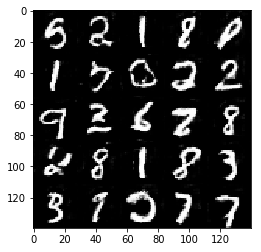

Epoch 2/2... Discriminator Loss: 0.4580... Generator Loss: 1.9998
Epoch 2/2... Discriminator Loss: 1.1046... Generator Loss: 0.6916
Epoch 2/2... Discriminator Loss: 1.1239... Generator Loss: 0.7301
Epoch 2/2... Discriminator Loss: 1.0219... Generator Loss: 0.6780
Epoch 2/2... Discriminator Loss: 1.3278... Generator Loss: 0.4845
Epoch 2/2... Discriminator Loss: 0.9891... Generator Loss: 0.6766
Epoch 2/2... Discriminator Loss: 0.9061... Generator Loss: 0.7872
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 1.0243
Epoch 2/2... Discriminator Loss: 0.9351... Generator Loss: 1.0569
Epoch 2/2... Discriminator Loss: 0.6875... Generator Loss: 1.2473


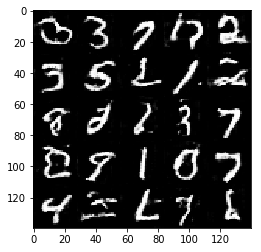

Epoch 2/2... Discriminator Loss: 0.7818... Generator Loss: 0.9424
Epoch 2/2... Discriminator Loss: 1.0682... Generator Loss: 0.6579
Epoch 2/2... Discriminator Loss: 2.6540... Generator Loss: 0.1159
Epoch 2/2... Discriminator Loss: 0.8676... Generator Loss: 0.8364
Epoch 2/2... Discriminator Loss: 1.1304... Generator Loss: 0.5697
Epoch 2/2... Discriminator Loss: 0.5671... Generator Loss: 1.2747
Epoch 2/2... Discriminator Loss: 1.3396... Generator Loss: 0.4629
Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 0.7582
Epoch 2/2... Discriminator Loss: 0.9554... Generator Loss: 0.7826
Epoch 2/2... Discriminator Loss: 0.9027... Generator Loss: 0.8633


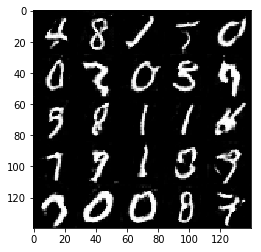

Epoch 2/2... Discriminator Loss: 1.0745... Generator Loss: 0.6191
Epoch 2/2... Discriminator Loss: 1.9077... Generator Loss: 0.3104
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 0.7875
Epoch 2/2... Discriminator Loss: 1.4194... Generator Loss: 0.5270
Epoch 2/2... Discriminator Loss: 1.8816... Generator Loss: 0.2542
Epoch 2/2... Discriminator Loss: 0.6733... Generator Loss: 3.4258
Epoch 2/2... Discriminator Loss: 1.9066... Generator Loss: 0.2962
Epoch 2/2... Discriminator Loss: 0.6186... Generator Loss: 2.0550
Epoch 2/2... Discriminator Loss: 0.9144... Generator Loss: 0.7887
Epoch 2/2... Discriminator Loss: 0.9152... Generator Loss: 0.7700


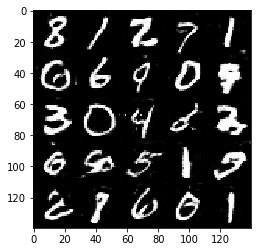

Epoch 2/2... Discriminator Loss: 0.7423... Generator Loss: 1.5154
Epoch 2/2... Discriminator Loss: 1.0668... Generator Loss: 0.7484
Epoch 2/2... Discriminator Loss: 2.2726... Generator Loss: 0.2110
Epoch 2/2... Discriminator Loss: 0.7729... Generator Loss: 0.9429
Epoch 2/2... Discriminator Loss: 1.0642... Generator Loss: 0.6467
Epoch 2/2... Discriminator Loss: 0.7716... Generator Loss: 1.0469
Epoch 2/2... Discriminator Loss: 0.7913... Generator Loss: 1.4019
Epoch 2/2... Discriminator Loss: 1.0253... Generator Loss: 0.7631
Epoch 2/2... Discriminator Loss: 0.5658... Generator Loss: 2.7199
Epoch 2/2... Discriminator Loss: 0.7460... Generator Loss: 1.0348


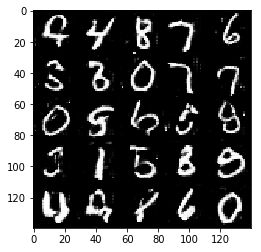

Epoch 2/2... Discriminator Loss: 2.3857... Generator Loss: 0.1861
Epoch 2/2... Discriminator Loss: 1.9895... Generator Loss: 0.2954
Epoch 2/2... Discriminator Loss: 0.5273... Generator Loss: 2.8490
Epoch 2/2... Discriminator Loss: 0.9376... Generator Loss: 0.8010
Epoch 2/2... Discriminator Loss: 0.9840... Generator Loss: 0.7626
Epoch 2/2... Discriminator Loss: 0.5371... Generator Loss: 1.2494
Epoch 2/2... Discriminator Loss: 1.0999... Generator Loss: 0.7180
Epoch 2/2... Discriminator Loss: 0.5605... Generator Loss: 1.3255
Epoch 2/2... Discriminator Loss: 0.8924... Generator Loss: 0.9295
Epoch 2/2... Discriminator Loss: 0.9247... Generator Loss: 0.7622


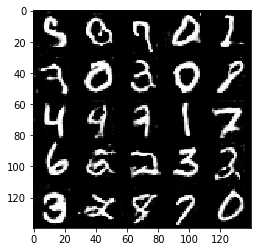

Epoch 2/2... Discriminator Loss: 1.9187... Generator Loss: 0.4013
Epoch 2/2... Discriminator Loss: 2.2962... Generator Loss: 0.2520
Epoch 2/2... Discriminator Loss: 2.7224... Generator Loss: 0.1853
Epoch 2/2... Discriminator Loss: 0.7064... Generator Loss: 1.2850
Epoch 2/2... Discriminator Loss: 1.2278... Generator Loss: 0.5478
Epoch 2/2... Discriminator Loss: 0.6008... Generator Loss: 2.0180
Epoch 2/2... Discriminator Loss: 0.7211... Generator Loss: 1.1989
Epoch 2/2... Discriminator Loss: 2.5244... Generator Loss: 0.1900
Epoch 2/2... Discriminator Loss: 0.8080... Generator Loss: 0.9045
Epoch 2/2... Discriminator Loss: 1.7274... Generator Loss: 0.4033


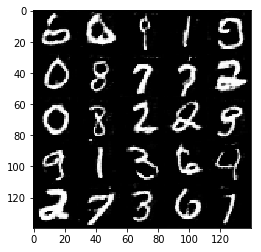

Epoch 2/2... Discriminator Loss: 1.0391... Generator Loss: 0.6778
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 0.6392
Epoch 2/2... Discriminator Loss: 1.0126... Generator Loss: 0.8009
Epoch 2/2... Discriminator Loss: 0.4174... Generator Loss: 1.8601
Epoch 2/2... Discriminator Loss: 0.5928... Generator Loss: 2.5822
Epoch 2/2... Discriminator Loss: 0.9653... Generator Loss: 0.8835
Epoch 2/2... Discriminator Loss: 0.7463... Generator Loss: 1.1463


In [31]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6881... Generator Loss: 0.3082
Epoch 1/1... Discriminator Loss: 1.7158... Generator Loss: 0.3327
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 0.8051... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 0.6533... Generator Loss: 1.0760
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 0.3896... Generator Loss: 1.3578
Epoch 1/1... Discriminator Loss: 0.2193... Generator Loss: 2.1933
Epoch 1/1... Discriminator Loss: 0.1490... Generator Loss: 2.5129


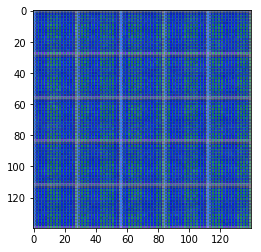

Epoch 1/1... Discriminator Loss: 0.2053... Generator Loss: 2.0249
Epoch 1/1... Discriminator Loss: 0.2155... Generator Loss: 2.0973
Epoch 1/1... Discriminator Loss: 0.1329... Generator Loss: 2.5512
Epoch 1/1... Discriminator Loss: 0.0873... Generator Loss: 3.1224
Epoch 1/1... Discriminator Loss: 0.0825... Generator Loss: 2.9760
Epoch 1/1... Discriminator Loss: 0.0188... Generator Loss: 6.5241
Epoch 1/1... Discriminator Loss: 0.1120... Generator Loss: 3.0734
Epoch 1/1... Discriminator Loss: 0.1162... Generator Loss: 2.7817
Epoch 1/1... Discriminator Loss: 0.0469... Generator Loss: 4.2066
Epoch 1/1... Discriminator Loss: 0.0271... Generator Loss: 4.6856


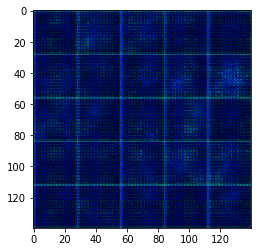

Epoch 1/1... Discriminator Loss: 0.2141... Generator Loss: 2.5362
Epoch 1/1... Discriminator Loss: 0.0660... Generator Loss: 3.5058
Epoch 1/1... Discriminator Loss: 0.0312... Generator Loss: 4.9848
Epoch 1/1... Discriminator Loss: 0.1027... Generator Loss: 3.1861
Epoch 1/1... Discriminator Loss: 0.0458... Generator Loss: 4.0607
Epoch 1/1... Discriminator Loss: 0.0667... Generator Loss: 4.1956
Epoch 1/1... Discriminator Loss: 0.0071... Generator Loss: 9.9038
Epoch 1/1... Discriminator Loss: 0.1187... Generator Loss: 3.5707
Epoch 1/1... Discriminator Loss: 0.1027... Generator Loss: 4.3851
Epoch 1/1... Discriminator Loss: 0.1982... Generator Loss: 2.5404


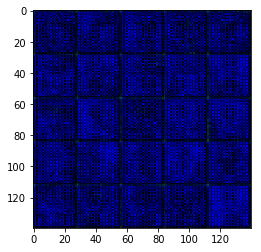

Epoch 1/1... Discriminator Loss: 0.0991... Generator Loss: 3.4153
Epoch 1/1... Discriminator Loss: 0.0506... Generator Loss: 5.1717
Epoch 1/1... Discriminator Loss: 0.1732... Generator Loss: 3.0720
Epoch 1/1... Discriminator Loss: 0.0722... Generator Loss: 3.5021
Epoch 1/1... Discriminator Loss: 0.0949... Generator Loss: 3.2057
Epoch 1/1... Discriminator Loss: 0.1581... Generator Loss: 2.7604
Epoch 1/1... Discriminator Loss: 0.0987... Generator Loss: 3.7380
Epoch 1/1... Discriminator Loss: 0.0856... Generator Loss: 3.4233
Epoch 1/1... Discriminator Loss: 0.0447... Generator Loss: 4.7042
Epoch 1/1... Discriminator Loss: 0.0835... Generator Loss: 3.2263


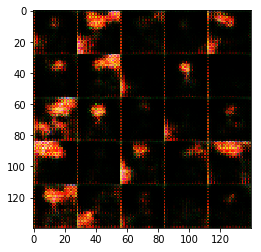

Epoch 1/1... Discriminator Loss: 4.8888... Generator Loss: 0.0802
Epoch 1/1... Discriminator Loss: 0.2285... Generator Loss: 6.3086
Epoch 1/1... Discriminator Loss: 0.0783... Generator Loss: 5.6393
Epoch 1/1... Discriminator Loss: 0.1650... Generator Loss: 3.1897
Epoch 1/1... Discriminator Loss: 0.7965... Generator Loss: 1.3648
Epoch 1/1... Discriminator Loss: 0.2366... Generator Loss: 2.5271
Epoch 1/1... Discriminator Loss: 0.1322... Generator Loss: 2.9092
Epoch 1/1... Discriminator Loss: 0.0510... Generator Loss: 8.9894
Epoch 1/1... Discriminator Loss: 0.0501... Generator Loss: 5.2199
Epoch 1/1... Discriminator Loss: 0.1074... Generator Loss: 3.4911


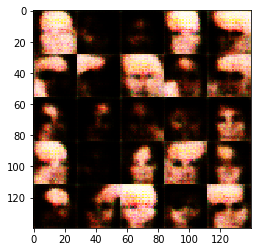

Epoch 1/1... Discriminator Loss: 0.1204... Generator Loss: 3.0298
Epoch 1/1... Discriminator Loss: 0.0925... Generator Loss: 3.3915
Epoch 1/1... Discriminator Loss: 0.4784... Generator Loss: 2.3766
Epoch 1/1... Discriminator Loss: 0.0736... Generator Loss: 3.7961
Epoch 1/1... Discriminator Loss: 0.0611... Generator Loss: 4.1807
Epoch 1/1... Discriminator Loss: 0.0780... Generator Loss: 4.4188
Epoch 1/1... Discriminator Loss: 0.0393... Generator Loss: 4.9652
Epoch 1/1... Discriminator Loss: 0.0741... Generator Loss: 4.7908
Epoch 1/1... Discriminator Loss: 0.0544... Generator Loss: 4.2713
Epoch 1/1... Discriminator Loss: 0.2182... Generator Loss: 2.3069


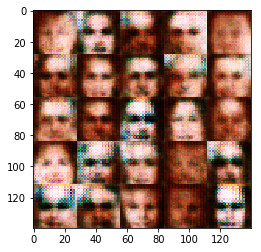

Epoch 1/1... Discriminator Loss: 0.3359... Generator Loss: 5.3393
Epoch 1/1... Discriminator Loss: 0.0856... Generator Loss: 4.7791
Epoch 1/1... Discriminator Loss: 0.1346... Generator Loss: 3.2261
Epoch 1/1... Discriminator Loss: 0.1488... Generator Loss: 3.1641
Epoch 1/1... Discriminator Loss: 0.1526... Generator Loss: 3.5848
Epoch 1/1... Discriminator Loss: 0.0772... Generator Loss: 3.5341
Epoch 1/1... Discriminator Loss: 0.2340... Generator Loss: 2.6475
Epoch 1/1... Discriminator Loss: 0.1510... Generator Loss: 3.2748
Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 1.3269
Epoch 1/1... Discriminator Loss: 0.3160... Generator Loss: 4.8241


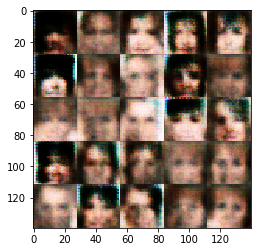

Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 7.8954
Epoch 1/1... Discriminator Loss: 0.1834... Generator Loss: 3.1137
Epoch 1/1... Discriminator Loss: 0.3691... Generator Loss: 1.7411
Epoch 1/1... Discriminator Loss: 0.2975... Generator Loss: 2.1224
Epoch 1/1... Discriminator Loss: 0.3017... Generator Loss: 5.0743
Epoch 1/1... Discriminator Loss: 0.1786... Generator Loss: 2.8815
Epoch 1/1... Discriminator Loss: 0.3091... Generator Loss: 2.3266
Epoch 1/1... Discriminator Loss: 0.1338... Generator Loss: 3.1035
Epoch 1/1... Discriminator Loss: 0.3101... Generator Loss: 2.3815
Epoch 1/1... Discriminator Loss: 0.3136... Generator Loss: 2.5625


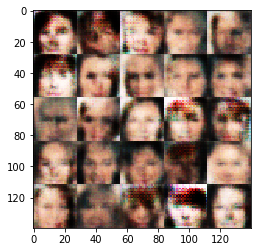

Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 0.2857... Generator Loss: 3.6309
Epoch 1/1... Discriminator Loss: 0.6447... Generator Loss: 1.3558
Epoch 1/1... Discriminator Loss: 0.6670... Generator Loss: 1.3989
Epoch 1/1... Discriminator Loss: 0.4138... Generator Loss: 1.8870
Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 3.8134
Epoch 1/1... Discriminator Loss: 0.4752... Generator Loss: 3.7671
Epoch 1/1... Discriminator Loss: 0.2051... Generator Loss: 3.1227
Epoch 1/1... Discriminator Loss: 0.4228... Generator Loss: 1.6292
Epoch 1/1... Discriminator Loss: 0.3774... Generator Loss: 2.1529


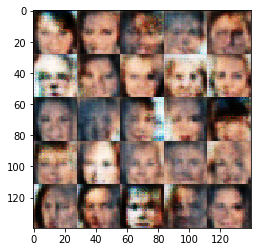

Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 0.3116... Generator Loss: 2.0913
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.5190
Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 2.2870
Epoch 1/1... Discriminator Loss: 0.3151... Generator Loss: 1.9552
Epoch 1/1... Discriminator Loss: 0.3301... Generator Loss: 1.7926
Epoch 1/1... Discriminator Loss: 0.3448... Generator Loss: 2.8882
Epoch 1/1... Discriminator Loss: 0.2716... Generator Loss: 3.0312
Epoch 1/1... Discriminator Loss: 0.4307... Generator Loss: 1.6495
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 1.4812


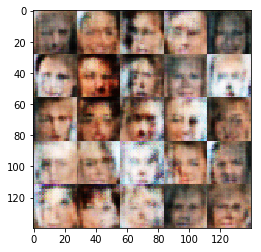

Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 4.0892
Epoch 1/1... Discriminator Loss: 0.2673... Generator Loss: 3.0261
Epoch 1/1... Discriminator Loss: 0.4644... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 2.4271
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 1.5579
Epoch 1/1... Discriminator Loss: 0.5397... Generator Loss: 1.3876
Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 1.3752
Epoch 1/1... Discriminator Loss: 0.3371... Generator Loss: 2.6996
Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 1.1868
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.3849


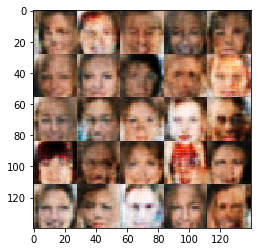

Epoch 1/1... Discriminator Loss: 0.3693... Generator Loss: 1.7044
Epoch 1/1... Discriminator Loss: 0.4269... Generator Loss: 1.6050
Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 1.1831
Epoch 1/1... Discriminator Loss: 0.2486... Generator Loss: 2.4496
Epoch 1/1... Discriminator Loss: 0.5771... Generator Loss: 1.1364
Epoch 1/1... Discriminator Loss: 0.3136... Generator Loss: 2.7140
Epoch 1/1... Discriminator Loss: 0.3151... Generator Loss: 1.8757
Epoch 1/1... Discriminator Loss: 0.4465... Generator Loss: 1.6766
Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 2.6667
Epoch 1/1... Discriminator Loss: 0.7008... Generator Loss: 0.9603


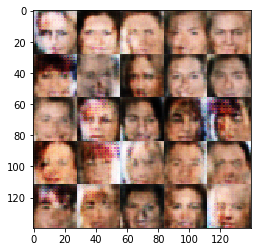

Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 2.3730
Epoch 1/1... Discriminator Loss: 0.5379... Generator Loss: 1.3412
Epoch 1/1... Discriminator Loss: 0.7110... Generator Loss: 1.2245
Epoch 1/1... Discriminator Loss: 0.2859... Generator Loss: 2.8868
Epoch 1/1... Discriminator Loss: 0.5402... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.4722
Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 1.2101
Epoch 1/1... Discriminator Loss: 0.6900... Generator Loss: 1.1327
Epoch 1/1... Discriminator Loss: 0.5170... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 0.4656... Generator Loss: 1.6131


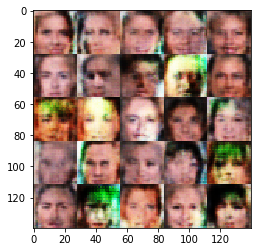

Epoch 1/1... Discriminator Loss: 0.4788... Generator Loss: 1.7663
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 1.9387
Epoch 1/1... Discriminator Loss: 0.3788... Generator Loss: 1.7770
Epoch 1/1... Discriminator Loss: 0.4766... Generator Loss: 1.4561
Epoch 1/1... Discriminator Loss: 0.3484... Generator Loss: 2.0876
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.5299
Epoch 1/1... Discriminator Loss: 0.4138... Generator Loss: 1.7957
Epoch 1/1... Discriminator Loss: 0.3948... Generator Loss: 1.6113
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 2.0006


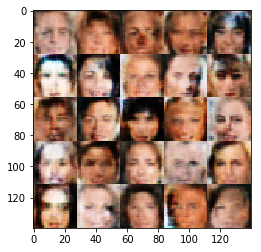

Epoch 1/1... Discriminator Loss: 0.4365... Generator Loss: 1.8633
Epoch 1/1... Discriminator Loss: 0.7783... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 0.7020... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 0.4301... Generator Loss: 1.5842
Epoch 1/1... Discriminator Loss: 0.3943... Generator Loss: 1.5794
Epoch 1/1... Discriminator Loss: 0.7497... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 0.6480... Generator Loss: 1.1457
Epoch 1/1... Discriminator Loss: 0.4526... Generator Loss: 1.4508
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 1.7345
Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 1.3041


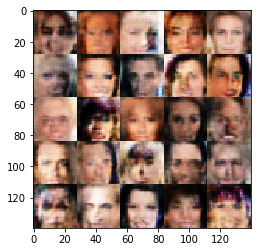

Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 1.6989
Epoch 1/1... Discriminator Loss: 0.4615... Generator Loss: 1.6771
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.4590
Epoch 1/1... Discriminator Loss: 0.4376... Generator Loss: 1.4126
Epoch 1/1... Discriminator Loss: 0.4839... Generator Loss: 3.0177
Epoch 1/1... Discriminator Loss: 0.6682... Generator Loss: 1.1289
Epoch 1/1... Discriminator Loss: 0.6793... Generator Loss: 1.0014
Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 1.3813
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 0.7989... Generator Loss: 0.9572


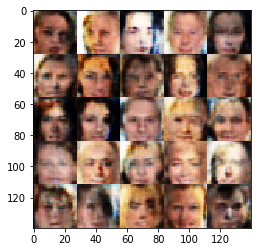

Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 0.5304... Generator Loss: 2.1814
Epoch 1/1... Discriminator Loss: 0.3322... Generator Loss: 1.8826
Epoch 1/1... Discriminator Loss: 0.5623... Generator Loss: 1.4416
Epoch 1/1... Discriminator Loss: 0.4448... Generator Loss: 1.6890
Epoch 1/1... Discriminator Loss: 0.5292... Generator Loss: 1.3579
Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 1.4285
Epoch 1/1... Discriminator Loss: 0.5654... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 0.6664... Generator Loss: 1.1040


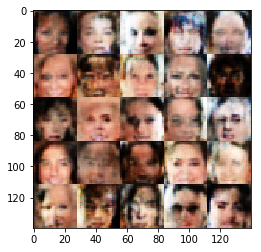

Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 2.1339
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 1.4791
Epoch 1/1... Discriminator Loss: 0.2681... Generator Loss: 1.9636
Epoch 1/1... Discriminator Loss: 0.6879... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 0.4527... Generator Loss: 1.7841
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 2.0019
Epoch 1/1... Discriminator Loss: 0.5370... Generator Loss: 1.4886
Epoch 1/1... Discriminator Loss: 0.4902... Generator Loss: 1.8000
Epoch 1/1... Discriminator Loss: 0.4315... Generator Loss: 1.8953


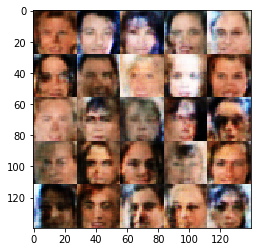

Epoch 1/1... Discriminator Loss: 0.7181... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 0.5251... Generator Loss: 1.3925
Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 1.1789
Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 1.5960
Epoch 1/1... Discriminator Loss: 0.5668... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 0.5583... Generator Loss: 1.2703
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 0.5196... Generator Loss: 1.5392
Epoch 1/1... Discriminator Loss: 0.6992... Generator Loss: 1.1646


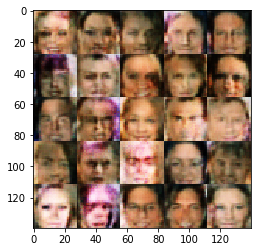

Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.3798
Epoch 1/1... Discriminator Loss: 0.4722... Generator Loss: 1.5676
Epoch 1/1... Discriminator Loss: 0.4768... Generator Loss: 1.7521
Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 0.2841... Generator Loss: 2.2770
Epoch 1/1... Discriminator Loss: 0.2175... Generator Loss: 3.0571
Epoch 1/1... Discriminator Loss: 0.5684... Generator Loss: 1.4451
Epoch 1/1... Discriminator Loss: 0.5417... Generator Loss: 1.2674
Epoch 1/1... Discriminator Loss: 0.2512... Generator Loss: 2.4689
Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 0.8277


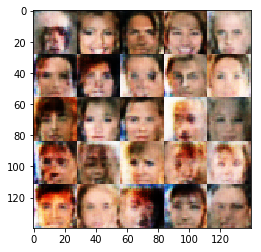

Epoch 1/1... Discriminator Loss: 0.6701... Generator Loss: 1.0745
Epoch 1/1... Discriminator Loss: 0.6229... Generator Loss: 1.2866
Epoch 1/1... Discriminator Loss: 0.2416... Generator Loss: 2.6494
Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 0.2936... Generator Loss: 2.7270
Epoch 1/1... Discriminator Loss: 0.7842... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 1.3892
Epoch 1/1... Discriminator Loss: 0.4846... Generator Loss: 1.9656
Epoch 1/1... Discriminator Loss: 0.5807... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 0.7053... Generator Loss: 1.5136


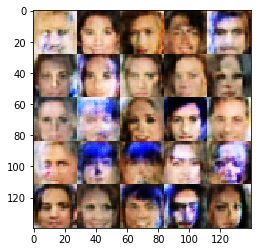

Epoch 1/1... Discriminator Loss: 0.6984... Generator Loss: 1.0115
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 1.7325
Epoch 1/1... Discriminator Loss: 0.5100... Generator Loss: 1.4657
Epoch 1/1... Discriminator Loss: 0.4283... Generator Loss: 1.5271
Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 1.4348
Epoch 1/1... Discriminator Loss: 0.4918... Generator Loss: 1.2054
Epoch 1/1... Discriminator Loss: 0.8421... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 1.2007
Epoch 1/1... Discriminator Loss: 0.7567... Generator Loss: 0.9137


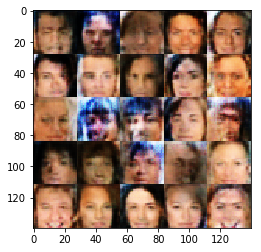

Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 0.7050... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 1.7027
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 1.7722
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 0.5455... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 2.3249
Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 1.5357


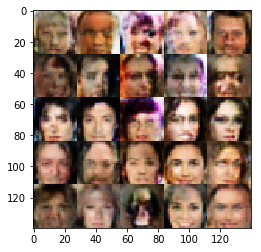

Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 0.5851... Generator Loss: 1.2960
Epoch 1/1... Discriminator Loss: 0.5989... Generator Loss: 1.2095
Epoch 1/1... Discriminator Loss: 0.5513... Generator Loss: 1.3147
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 1.8819
Epoch 1/1... Discriminator Loss: 0.3256... Generator Loss: 1.7745
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 0.5129... Generator Loss: 1.2694
Epoch 1/1... Discriminator Loss: 0.3047... Generator Loss: 1.9604


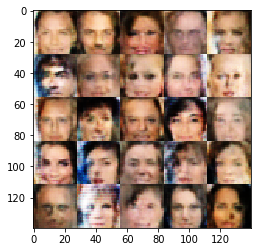

Epoch 1/1... Discriminator Loss: 0.7791... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 1.5291
Epoch 1/1... Discriminator Loss: 0.7537... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 0.6795... Generator Loss: 1.4244
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 1.2865
Epoch 1/1... Discriminator Loss: 0.6992... Generator Loss: 1.7320
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 1.0530


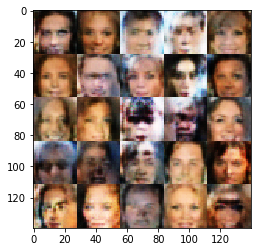

Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 1.6067
Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 1.5794
Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 0.7479... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 1.2055
Epoch 1/1... Discriminator Loss: 0.6622... Generator Loss: 1.2007
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 0.4926... Generator Loss: 1.3968
Epoch 1/1... Discriminator Loss: 0.5722... Generator Loss: 1.5596


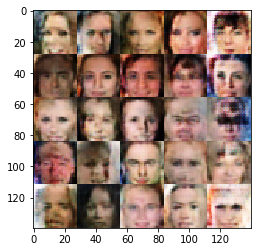

Epoch 1/1... Discriminator Loss: 0.8048... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.5414
Epoch 1/1... Discriminator Loss: 0.3673... Generator Loss: 1.8979
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 1.5578
Epoch 1/1... Discriminator Loss: 0.5768... Generator Loss: 1.4811
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 0.3203... Generator Loss: 2.1796
Epoch 1/1... Discriminator Loss: 0.7589... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 1.1454
Epoch 1/1... Discriminator Loss: 0.4192... Generator Loss: 1.6174


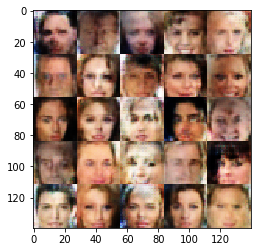

Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 0.2638... Generator Loss: 2.3654
Epoch 1/1... Discriminator Loss: 0.6984... Generator Loss: 1.0026
Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 1.6006
Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 1.2527
Epoch 1/1... Discriminator Loss: 1.7882... Generator Loss: 0.3234
Epoch 1/1... Discriminator Loss: 0.5543... Generator Loss: 1.6240
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 1.5371
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 0.4080... Generator Loss: 1.5736


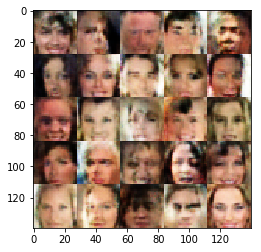

Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 1.8183... Generator Loss: 0.3016
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 0.6373... Generator Loss: 1.2379
Epoch 1/1... Discriminator Loss: 0.7779... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 1.2305
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 0.4312... Generator Loss: 1.5312
Epoch 1/1... Discriminator Loss: 0.5842... Generator Loss: 1.1661


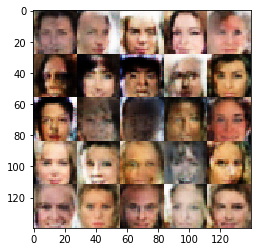

Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 1.2746
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 0.5573... Generator Loss: 1.3723
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.4005
Epoch 1/1... Discriminator Loss: 0.5838... Generator Loss: 1.3539
Epoch 1/1... Discriminator Loss: 0.3320... Generator Loss: 2.1767
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.0020


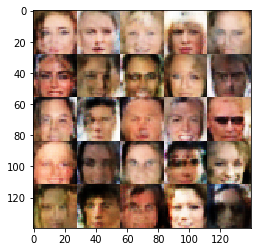

Epoch 1/1... Discriminator Loss: 0.4773... Generator Loss: 1.5448
Epoch 1/1... Discriminator Loss: 0.5926... Generator Loss: 1.4683
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 0.5917... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 0.4270... Generator Loss: 2.1594
Epoch 1/1... Discriminator Loss: 0.6922... Generator Loss: 1.2259
Epoch 1/1... Discriminator Loss: 0.6085... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 1.6523


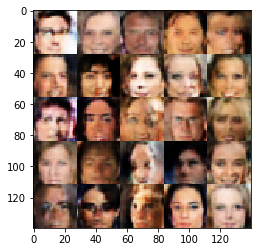

Epoch 1/1... Discriminator Loss: 0.6466... Generator Loss: 1.2278
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 0.6261... Generator Loss: 1.3572
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 1.8026


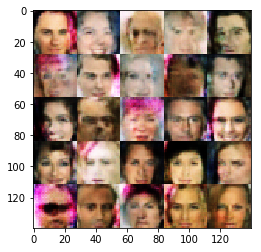

Epoch 1/1... Discriminator Loss: 0.5433... Generator Loss: 1.3823
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.4944
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 1.1509
Epoch 1/1... Discriminator Loss: 0.7712... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 1.4591
Epoch 1/1... Discriminator Loss: 0.6576... Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 1.2193
Epoch 1/1... Discriminator Loss: 0.8102... Generator Loss: 0.7792


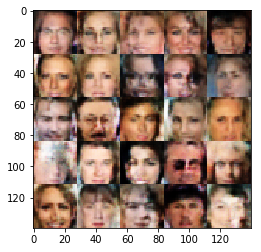

Epoch 1/1... Discriminator Loss: 0.7696... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 0.5468... Generator Loss: 1.4731
Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 1.2034
Epoch 1/1... Discriminator Loss: 0.3951... Generator Loss: 1.8401
Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 1.0987
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 0.6558... Generator Loss: 1.1786
Epoch 1/1... Discriminator Loss: 0.7105... Generator Loss: 1.1939
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 0.7696


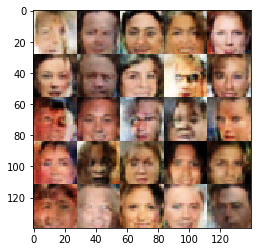

Epoch 1/1... Discriminator Loss: 0.6279... Generator Loss: 2.0803
Epoch 1/1... Discriminator Loss: 0.5366... Generator Loss: 1.4290
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.3973
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 0.6992... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 0.5539... Generator Loss: 1.6559
Epoch 1/1... Discriminator Loss: 0.6510... Generator Loss: 1.0377
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 0.7669


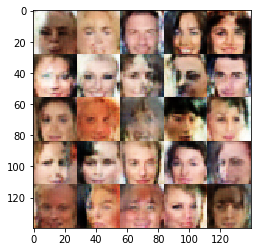

Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 1.2923
Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 0.5935... Generator Loss: 1.3325
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 0.5629... Generator Loss: 1.1886
Epoch 1/1... Discriminator Loss: 0.5849... Generator Loss: 1.2210
Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 1.2500
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 0.8665


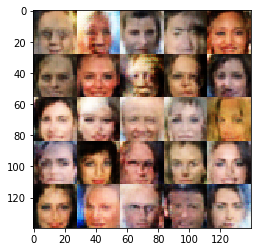

Epoch 1/1... Discriminator Loss: 0.6869... Generator Loss: 1.2170
Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 0.7492... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 0.4613... Generator Loss: 1.3827
Epoch 1/1... Discriminator Loss: 0.5991... Generator Loss: 1.3128
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 0.6556... Generator Loss: 1.3844
Epoch 1/1... Discriminator Loss: 2.2939... Generator Loss: 0.1570
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 0.9509


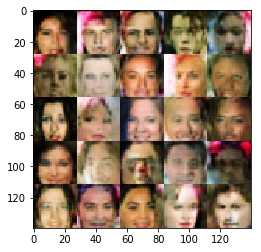

Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 0.6737... Generator Loss: 1.1863
Epoch 1/1... Discriminator Loss: 0.6045... Generator Loss: 1.2954
Epoch 1/1... Discriminator Loss: 1.7358... Generator Loss: 0.3695
Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 1.6150... Generator Loss: 0.2884
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 0.3332... Generator Loss: 1.8825
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 0.7298


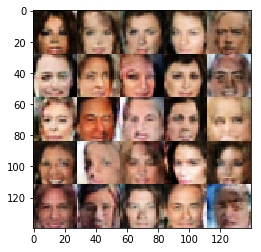

Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.4055
Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 0.9101
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 1.2576
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.4665


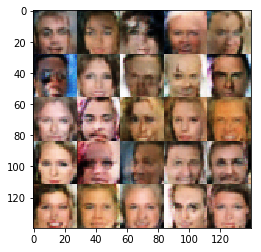

Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 0.5945... Generator Loss: 1.2126
Epoch 1/1... Discriminator Loss: 0.4465... Generator Loss: 1.5552
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 0.8235... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 0.5898... Generator Loss: 1.1948
Epoch 1/1... Discriminator Loss: 0.4966... Generator Loss: 1.4994


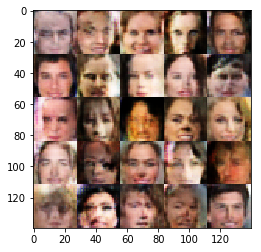

Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.4735
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 0.6977... Generator Loss: 1.2103
Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 1.0979
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 0.3678... Generator Loss: 1.5707
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.4416


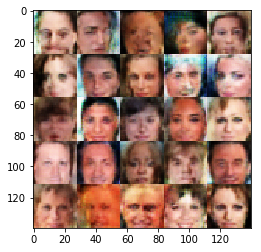

Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 0.8456... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 1.2457
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 0.5374... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 0.7379


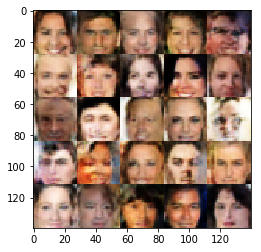

Epoch 1/1... Discriminator Loss: 0.6084... Generator Loss: 1.3943
Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 1.1221
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 1.1817
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 1.6529
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.7288... Generator Loss: 0.3044
Epoch 1/1... Discriminator Loss: 0.7435... Generator Loss: 0.9952


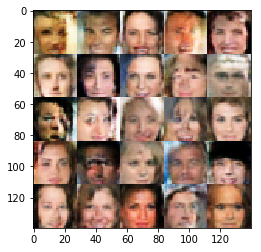

Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 0.7308... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 0.6884... Generator Loss: 1.0964
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.5508
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 1.4431


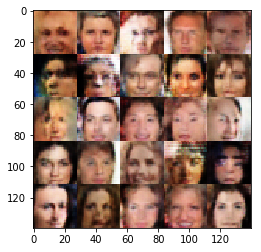

Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.3770
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 0.4163... Generator Loss: 1.6504
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 1.2607
Epoch 1/1... Discriminator Loss: 0.7138... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 1.2741
Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 0.7789


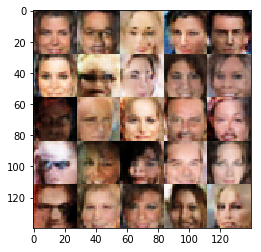

Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 0.3401
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 1.2291
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.4335
Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 1.1967
Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.4155


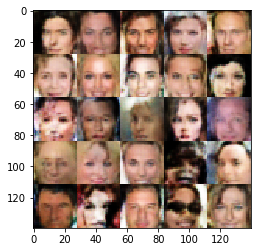

Epoch 1/1... Discriminator Loss: 0.7094... Generator Loss: 1.1096
Epoch 1/1... Discriminator Loss: 0.6954... Generator Loss: 1.1301
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.4931
Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.4737
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 1.4954
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 0.8396


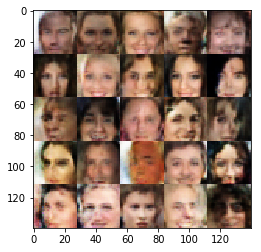

Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 1.4869
Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 0.8645


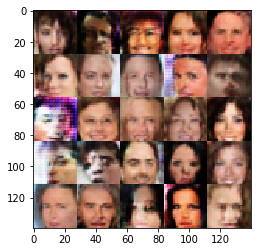

Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 0.7363... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 0.6461... Generator Loss: 1.3647
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 0.7641... Generator Loss: 1.1058
Epoch 1/1... Discriminator Loss: 0.7205... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 0.7895


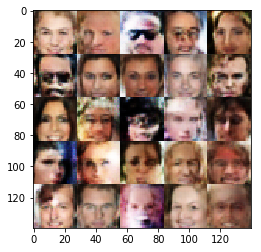

Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.4426
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.4417
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 0.7782... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 0.8483... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 0.7723... Generator Loss: 0.8930


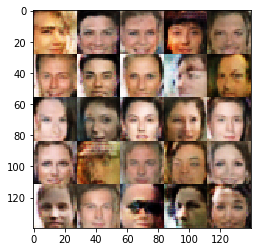

Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.4179
Epoch 1/1... Discriminator Loss: 0.5801... Generator Loss: 1.6049
Epoch 1/1... Discriminator Loss: 0.7441... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 1.4557
Epoch 1/1... Discriminator Loss: 0.8802... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.3461
Epoch 1/1... Discriminator Loss: 0.6678... Generator Loss: 1.3634
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.5995


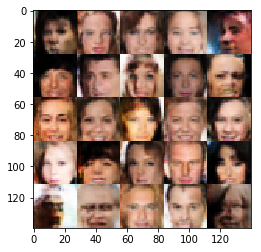

Epoch 1/1... Discriminator Loss: 0.8038... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 0.6769... Generator Loss: 1.2513
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 0.6278... Generator Loss: 1.2272
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.6367... Generator Loss: 0.3814
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 0.7103... Generator Loss: 1.2682


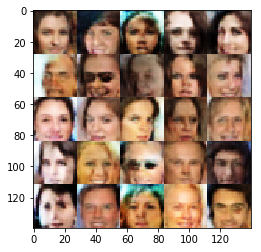

Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.4312
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 0.7519... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.5910


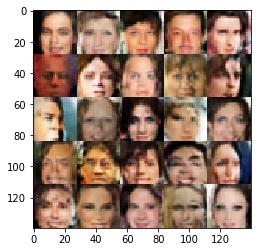

Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 0.4658... Generator Loss: 1.8044
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.4419


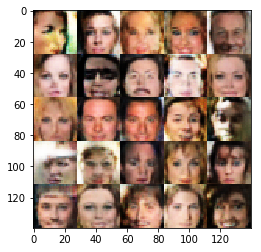

Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 0.9434
Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 1.1475
Epoch 1/1... Discriminator Loss: 0.6687... Generator Loss: 1.2396
Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 0.7223... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 2.4440... Generator Loss: 0.1861
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 0.7679


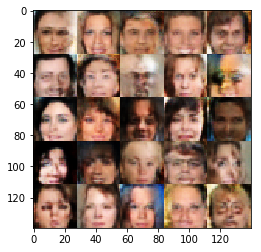

Epoch 1/1... Discriminator Loss: 0.6943... Generator Loss: 1.4745
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.4865
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.7127... Generator Loss: 0.2638
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 0.7968... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 0.6632


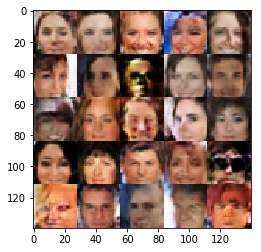

Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.4511
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 1.5704
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 0.6752... Generator Loss: 1.1433
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 0.6853... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 0.7905... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 1.0960


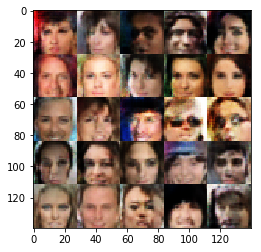

Epoch 1/1... Discriminator Loss: 0.7508... Generator Loss: 1.0650
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 0.4846... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 1.1943
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 1.2559
Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.5197


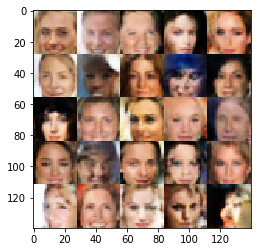

Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 1.4009
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.4439


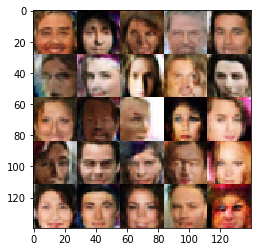

Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.1621
Epoch 1/1... Discriminator Loss: 0.7330... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 1.8168... Generator Loss: 0.2823
Epoch 1/1... Discriminator Loss: 0.7221... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 1.1459
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 0.7862


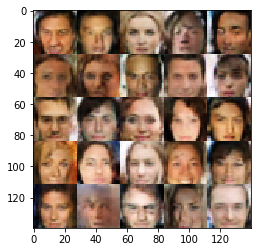

Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 0.4290... Generator Loss: 1.6372
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 0.6466... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.4817
Epoch 1/1... Discriminator Loss: 0.3963... Generator Loss: 1.9687


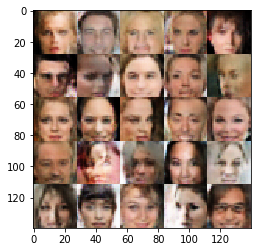

Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 0.5780... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.4228
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 0.7217... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 0.7123... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 0.9357


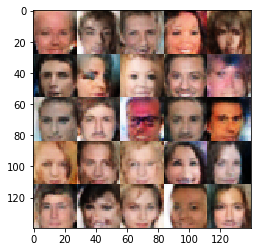

Epoch 1/1... Discriminator Loss: 0.7181... Generator Loss: 1.1984
Epoch 1/1... Discriminator Loss: 0.4991... Generator Loss: 1.6684
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.4459
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 0.8431... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.6800... Generator Loss: 0.4689


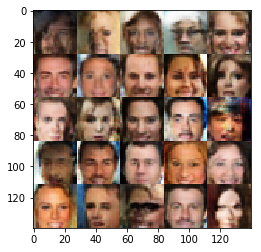

Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 0.7723


In [32]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.